In [10]:
import os
import zipfile

if not os.path.isdir("source"):
   with zipfile.ZipFile("source.zip", 'r') as zip_ref:
      zip_ref.extractall(".")

if not os.path.isdir("data"):
   with zipfile.ZipFile("data.zip", 'r') as zip_ref:
      zip_ref.extractall(".")  

In [2]:
import gzip
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image
import code
import tensorflow.python.platform
import numpy
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as backend
import tensorflow_addons as tfa
import source.mask_to_submission as submission_maker
import source.constants as cst
import source.images as images

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def recall(y, predictions):
    true_positives = backend.sum(backend.round(backend.clip(y * predictions, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision(y, predictions):
    true_positives = backend.sum(backend.round(backend.clip(y * predictions, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_metric(y, predictions):
    pre = precision(y, predictions)
    rec = recall(y, predictions)
    return 2 * ((pre * rec) / (pre + rec + backend.epsilon()))

In [4]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, reduction=tf.keras.losses.Reduction.AUTO, name='focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)

        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.math.exp(-bce_loss)

        return self.alpha * tf.math.pow(1-pt, self.gamma) * bce_loss -\
               (1-self.alpha) * tf.math.pow(pt, self.gamma) * tf.math.log(1-pt)


In [5]:
def get_unet():
    inputs = layers.Input((200, 200, 3), name="input_layer")
    drop1 = layers.Dropout(cst.DROPOUT_PROBABILITY)(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2), (2, 2))(conv1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2), (2, 2))(conv2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2), (2, 2))(conv3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2), (2, 2))(conv4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    cropped6 = tf.image.resize_with_crop_or_pad(conv4, up6.shape[1], up6.shape[2])
    conc6 = layers.concatenate([up6, cropped6], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conc6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    cropped7 = tf.image.resize_with_crop_or_pad(conv3, up7.shape[1], up7.shape[2])
    conc7 = layers.concatenate([up7, cropped7], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conc7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    cropped8 = tf.image.resize_with_crop_or_pad(conv2, up8.shape[1], up8.shape[2])
    conc8 = layers.concatenate([up8, cropped8], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conc8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    cropped9 = tf.image.resize_with_crop_or_pad(conv1, up9.shape[1], up9.shape[2])
    conc9 = layers.concatenate([up9, cropped9], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conc9)
    drop10 = layers.Dropout(cst.DROPOUT_PROBABILITY)(conv9)
    conv10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(drop10)
    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid', name="output_layer")(conv10)

    unet = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    unet.compile(optimizer='adam', loss=FocalLoss(alpha=0.75, gamma=5.0), metrics=[f1_metric, 'accuracy'])
    return unet

In [6]:
def train_unet(unet):
    
    train_data_filename = cst.TRAIN_DIR + 'images/'
    train_labels_filename = cst.TRAIN_DIR + 'groundtruth/' 

    # Extract it into numpy arrays.
    train_data, mean_train, std_train = images.load_training(train_data_filename, cst.TRAINING_SIZE)
    train_labels = images.load_groundtruths(train_labels_filename, cst.TRAINING_SIZE)

    print("DATA SHAPE " + str(train_data.shape))
    print("TRAIN_LABELS SHAPE " + str(train_labels.shape))

    unet.summary()
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(cst.SAVE_NETWORK_FILE, monitor='f1_metric', save_best_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='f1_metric', patience=10, restore_best_weights = True, mode = 'max')
    output_shape = unet.get_layer("output_layer").output_shape
    margin = int((train_labels.shape[1] - output_shape[1]) / 2)
    right_margin = int(output_shape[1] + margin)
    train_labels = train_labels[:,margin:right_margin,margin:right_margin]

    history = unet.fit(train_data, train_labels, epochs=cst.NUM_EPOCHS, validation_split=cst.VALIDATION_SPLIT, batch_size=cst.BATCH_SIZE, callbacks=[model_checkpoint])
    #unet.save(cst.SAVE_NETWORK_FILE)
    train_data = None
    train_labels = None

    return mean_train, std_train, history

In [7]:
def predict():
    
    unet = get_unet()
    mean_train, std_train, history = train_unet(unet)

    input_size = unet.get_layer("input_layer").input_shape[0][1]
    output_size = unet.get_layer("output_layer").output_shape[1]

    test_data = images.load_test(cst.TEST_DIR, cst.TEST_SIZE, input_size, output_size, mean_train, std_train)
    
    masks = unet.predict(test_data, verbose=1)
    numpy.save("image_mask.npy", masks)

    return masks, history

In [8]:
def generate_masks(masks):
    predictions = []
    if not os.path.isdir(cst.OUTPUT_DIR):
        os.mkdir(cst.OUTPUT_DIR)
    print(masks.shape)
    for i in range(0, 800, 16):
        mask_line_1 = numpy.concatenate((masks[i], masks[i + 1], masks[i + 2], masks[i + 3]), axis=1)
        mask_line_2 = numpy.concatenate((masks[i + 4], masks[i + 5], masks[i + 6], masks[i + 7]), axis=1)
        mask_line_3 = numpy.concatenate((masks[i + 8], masks[i + 9], masks[i + 10], masks[i + 11]), axis=1)
        mask_line_4 = numpy.concatenate((masks[i + 12], masks[i + 13], masks[i + 14], masks[i + 15]), axis=1)
        mask = numpy.concatenate((mask_line_1, mask_line_2, mask_line_3, mask_line_4), axis=0)[0:608, 0:608, :]
        mask = mask.reshape((608, 608))
        mask = numpy.around(mask).astype('float64')
        for k in range(0, 608, 16):
            for l in range(0, 608, 16):
                patch = mask[k:k + 16, l:l + 16]
                summed = numpy.sum(patch)
                if summed >= (16 * 16 * cst.PIXEL_THRESHOLD):
                    mask[k:k + 16, l:l + 16].fill(1)
                else:
                    mask[k:k + 16, l:l + 16].fill(0)
        predictions.append(mask)
        Image.fromarray(images.img_float_to_uint8(mask)).save(cst.OUTPUT_DIR + "mask_%d.png" % ((i / 16) + 1))

In [9]:
masks, history = predict()

Loading data/training/images/satImage_001.png
Loading data/training/images/satImage_002.png
Loading data/training/images/satImage_003.png
Loading data/training/images/satImage_004.png
Loading data/training/images/satImage_005.png
Loading data/training/images/satImage_006.png
Loading data/training/images/satImage_007.png
Loading data/training/images/satImage_008.png
Loading data/training/images/satImage_009.png
Loading data/training/images/satImage_010.png
Loading data/training/images/satImage_011.png
Loading data/training/images/satImage_012.png
Loading data/training/images/satImage_013.png
Loading data/training/images/satImage_014.png
Loading data/training/images/satImage_015.png
Loading data/training/images/satImage_016.png
Loading data/training/images/satImage_017.png
Loading data/training/images/satImage_018.png
Loading data/training/images/satImage_019.png
Loading data/training/images/satImage_020.png
Loading data/training/images/satImage_021.png
Loading data/training/images/satIm

In [10]:
import os
generate_masks(masks)

(800, 192, 192, 1)


In [11]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
f1_metric = history.history['f1_metric']
accuracy = history.history['accuracy']
val_f1_metric = history.history['val_f1_metric']
val_accuracy = history.history['val_accuracy']

In [12]:
import numpy as np
if not os.path.exists('savedlosses/'):
        os.makedirs('savedlosses/')
np.save('savedlosses/training_loss.npy',training_loss)
np.save('savedlosses/test_loss.npy',test_loss)
np.save('savedlosses/f1_metric.npy',f1_metric)
np.save('savedlosses/accuracy.npy',accuracy)
np.save('savedlosses/val_f1_metric.npy',val_f1_metric)
np.save('savedlosses/val_accuracy.npy',val_accuracy)

import shutil
shutil.make_archive('savedlosses', 'zip', 'savedlosses')
from google.colab import files
files.download( 'savedlosses.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

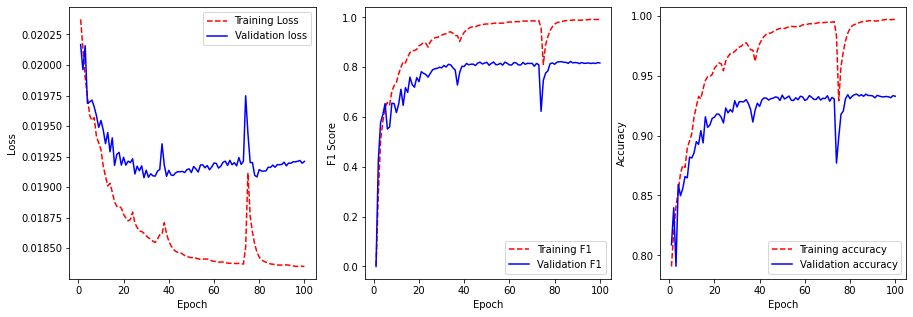

In [13]:
import matplotlib.pyplot as plt
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
fig = plt.figure(figsize = (15,5))
ax1 = plt.subplot(1,3,1)
# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label = 'Training Loss')
ax1.plot(epoch_count, test_loss, 'b-', label = 'Validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax1 = plt.subplot(1,3,2)
ax1.plot(epoch_count, f1_metric, 'r--', label = 'Training F1')
ax1.plot(epoch_count, val_f1_metric, 'b-', label = 'Validation F1')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1 Score')

ax1 = plt.subplot(1,3,3)
ax1.plot(epoch_count, accuracy, 'r--', label = 'Training accuracy')
ax1.plot(epoch_count, val_accuracy, 'b-', label = 'Validation accuracy')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
plt.show();

In [18]:
unet = get_unet()
unet.save('ourmodel')

shutil.make_archive('ourmodel', 'zip', 'ourmodel')
files.download( 'ourmodel.zip')

INFO:tensorflow:Assets written to: ourmodel/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
submission_filename = 'submit.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'data/predictions/mask_' + '%d' % i + '.png'
    print(image_filename)
    image_filenames.append(image_filename)
submission_maker.masks_to_submission(submission_filename, *image_filenames)

data/predictions/mask_1.png
data/predictions/mask_2.png
data/predictions/mask_3.png
data/predictions/mask_4.png
data/predictions/mask_5.png
data/predictions/mask_6.png
data/predictions/mask_7.png
data/predictions/mask_8.png
data/predictions/mask_9.png
data/predictions/mask_10.png
data/predictions/mask_11.png
data/predictions/mask_12.png
data/predictions/mask_13.png
data/predictions/mask_14.png
data/predictions/mask_15.png
data/predictions/mask_16.png
data/predictions/mask_17.png
data/predictions/mask_18.png
data/predictions/mask_19.png
data/predictions/mask_20.png
data/predictions/mask_21.png
data/predictions/mask_22.png
data/predictions/mask_23.png
data/predictions/mask_24.png
data/predictions/mask_25.png
data/predictions/mask_26.png
data/predictions/mask_27.png
data/predictions/mask_28.png
data/predictions/mask_29.png
data/predictions/mask_30.png
data/predictions/mask_31.png
data/predictions/mask_32.png
data/predictions/mask_33.png
data/predictions/mask_34.png
data/predictions/mask_3

In [31]:
def make_img_overlay(img, predicted_img):
    PIXEL_DEPTH = 255
    w = img.shape[0]
    h = img.shape[1]
    color_mask = numpy.zeros((w, h, 3), dtype=numpy.uint8)
    color_mask[:, :, 0] = predicted_img*PIXEL_DEPTH

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

In [27]:
data1 = mpimg.imread('data/predictions/mask_50.png')
data2 = mpimg.imread('data/test/test_50/test_50.png')
data1.shape, data2.shape

((608, 608), (608, 608, 3))

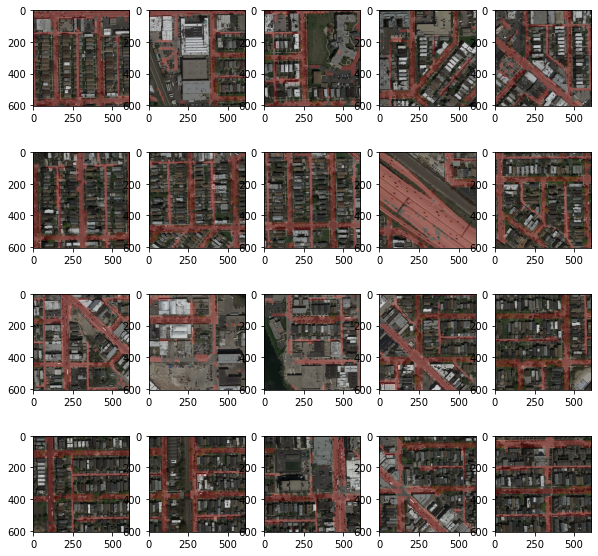

In [41]:
import matplotlib.image as mpimg
fig = plt.figure(figsize = (10,10))
for i in range(1,21):
  ax1 = plt.subplot(4,5,i)
  pred = mpimg.imread(f'data/predictions/mask_{i}.png')
  under = mpimg.imread(f'data/test/test_{i}/test_{i}.png')
  new_img = make_img_overlay(under, pred)
  ax1.imshow(new_img)
plt.show()

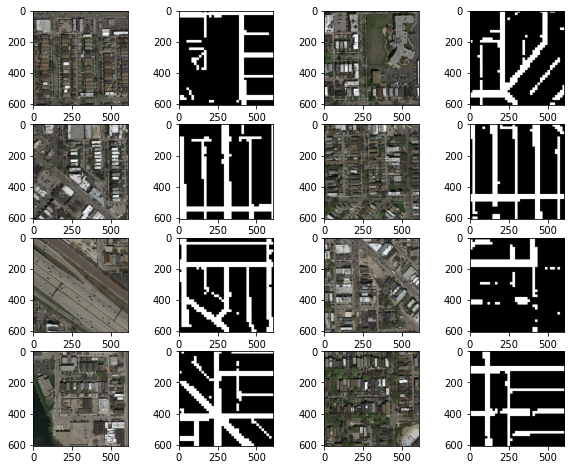

In [52]:
import matplotlib.image as mpimg
fig = plt.figure(figsize = (10,8))
for i in range(1,17):
  ax1 = plt.subplot(4,4,i)
  pred = mpimg.imread(f'data/predictions/mask_{i}.png')
  under = mpimg.imread(f'data/test/test_{i}/test_{i}.png')
  if i%2 == 0:
    ax1.imshow(pred,  cmap='Greys_r')
  else:
    ax1.imshow(under)
plt.show()